In [3]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [6]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#print(tf.__version__)
#print(keras.__version__)

In [7]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


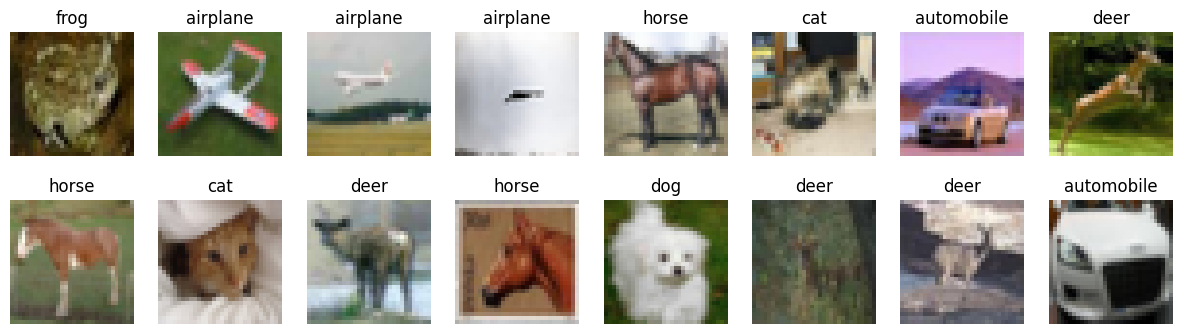

In [8]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [9]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [14]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [42]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.



    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())


    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))


    model.add(Dense(10, activation='softmax'))


    ### END STUDENT CODE ###

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax"))

    return model

In [44]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 200


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/200
1250/1250 [==============================] - 12s 7ms/step - loss: 2.1610 - accuracy: 0.2928 - val_loss: 2.0586 - val_accuracy: 0.3942
Epoch 2/200
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0573 - accuracy: 0.4002 - val_loss: 1.9967 - val_accuracy: 0.4627
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0087 - accuracy: 0.4501 - val_loss: 1.9589 - val_accuracy: 0.5012
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9748 - accuracy: 0.4855 - val_loss: 1.9545 - val_accuracy: 0.5061
Epoch 5/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9481 - accuracy: 0.5124 - val_loss: 1.9152 - val_accuracy: 0.5448
Epoch 6/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9238 - accuracy: 0.5384 - val_loss: 1.9015 - val_accuracy: 0.5597
Epoch 7/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9060 - accuracy: 0.5556 - val_loss: 1.8750 - val_a

In [45]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

313/313 [==============================] - 1s 4ms/step


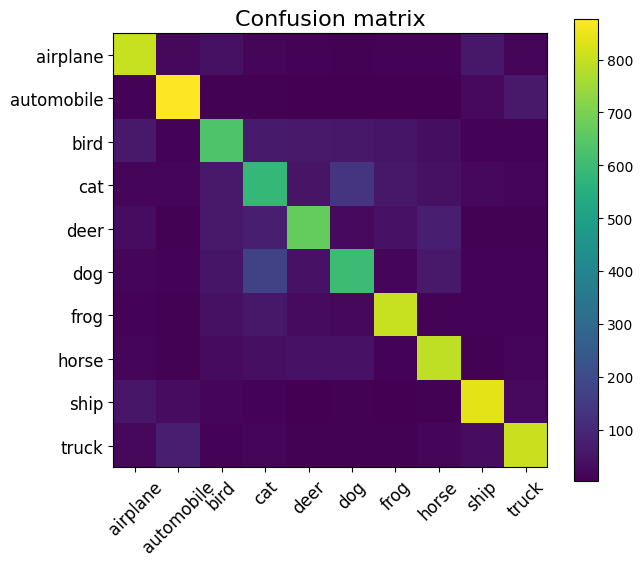

Test accuracy: 0.7411


In [46]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

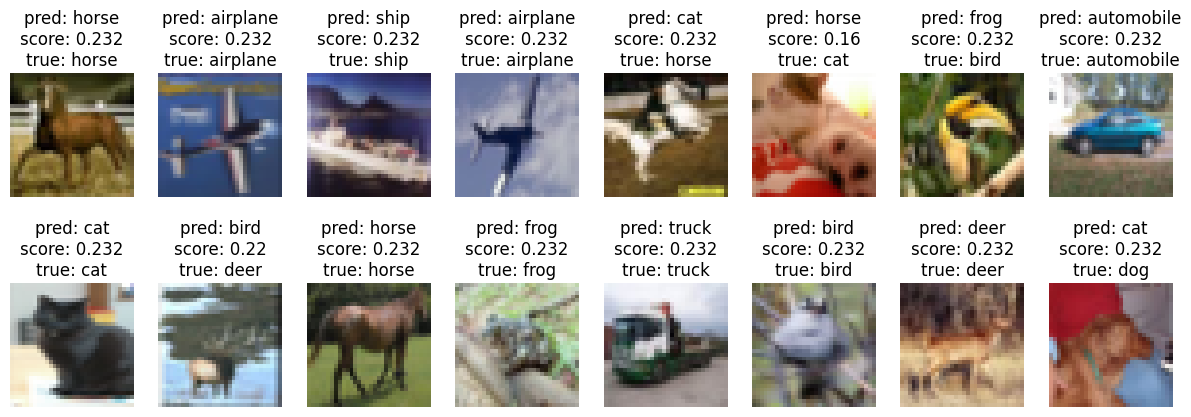

In [48]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




For the first model, after training it for 100 epochs I managed to achieve the accuracy during training of 0.8182 and the test accuracy of 0.7027. Its structure was as follows:



    model = Sequential()

add the first convolution layer with a small kernel size of 3 in order to learn the basic features. The number of filters in this one is 32 and in the second one 64 - the idea is to first use lower number of filters and increase it over the layers - this is done to capture the low-level feautures in the initial layers and then gradually increase the complexity. The ReLU activation function is used as it is non-linear which enables the model to learn more complex features but is not as computationally efficient than functions such as tanh.


    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))

the max pooling layer essentially downscales the image (in this case by a factor of two) which reduces the computational complexity. More importantly it "provides a translational invariance" which means that the model is not sensitive to where a specific feature is located which makes it more general and efficient.
 (https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo)

    model.add(MaxPooling2D(pool_size=(2, 2)))

here there is another convolution layer implemented, this time with 64 filters to increase the complexity of the features it learns

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

another max pooling layer for the same reasons as above

    model.add(MaxPooling2D(pool_size=(2, 2)))

here the output is flattened to a 1D array as the dense layers only accept such inputs

    model.add(Flatten())

dense layers are added. in other words they are fully-connected layers, which means that each neuron of the dense layer recieves input from all the neurons of the preceeding layer. this allows for learning even more complex patterns. the activation function in both are relu for their non-linear properties.
(https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/)

additionally a dropout layer is added - this randomly sets the input of a fraction of neurons to zero (with 50% probability) to prevent overfitting and to regularize the output

(https://databasecamp.de/en/ml/dropout-layer-en#:~:text=The%20dropout%20layer%20is%20a,the%20network%20architecture%20at%20all.)

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

the last dense layer has 10 neurons - the same as the number of classes in that dataset. the softmax activation makes the output of the previous layer normalized and can be interpreted as probability distribution over classes - it ensures the probabilities of each are between 0 and 1 and add up to 1.

(https://en.wikipedia.org/wiki/Softmax_function#:~:text=The%20softmax%20function%20is%20often,based%20on%20Luce's%20choice%20axiom.)

(https://keras.io/api/layers/activations/#:~:text=Softmax%20is%20often%20used%20as,odds%20of%20the%20resulting%20probability.)

    model.add(Dense(10, activation='softmax'))


    return model

the confusion matrix of the previous model is:

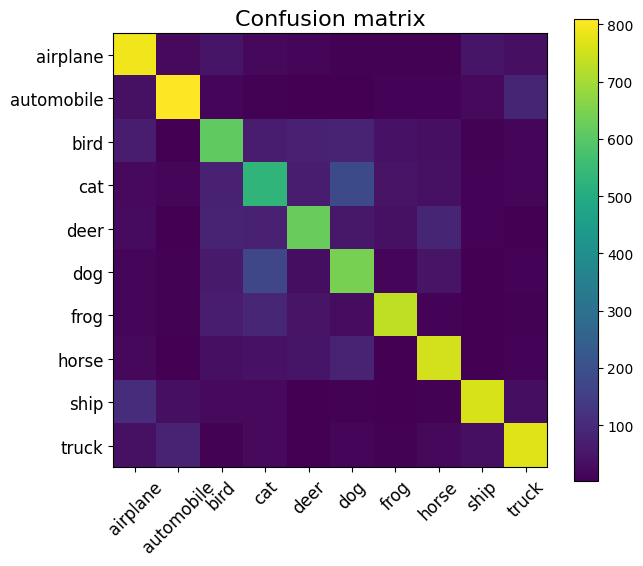

the second model is implemented in the actual code. what I changed in it as compared to the first model is:
- the concovolution layers now have 64 and 128 filters respectively (from 32 and 64), which allows for even better detection of features

- the number of neurons in the dense layers have been increased twofold, which also might be th ereason the model perfofrmed better

What is interesting to observe is that the second model achieved the 0.7 test accuracy (tracking the val_accuracy) much quicker, around 26th epoch. This was great, however it achieved the val_accuracy of above 0.73 around epoch 56 and then just circulated around that area. It means that with this code this seems to be the value of accuracy it roughly converges to. This time I trained the model for 200 instead of 100 epoch, but the only value that seemed to improve thanks to that was the accuracy during training - it went from around 0.8 to almost 0.95. The model could probably still be improved, but I was pretty satisfied with the results.